# GreditG ArgueView Example

This example showcases the use of ArgueView in a realistic usage scenario. We will use the 
following tools:
- [CreditG dataset](https://www.openml.org/d/31)
- scikit-learn's RandomForest classifier
- [LIME](https://github.com/marcotcr/lime)'s black-box explainer

![Procedure visualization](https://github.com/sophiahadash/argueview/blob/master/screenshots/model.png?raw=true)

Make sure to install all development dependencies prior to running this example: 
`pipenv install --dev`

In [1]:
import json
import os
import lime
import lime.lime_tabular
import numpy as np
import openml as oml
import pandas as pd
import requests
from openml import OpenMLDataset
import settings
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from argueview.typings import Source, OpenMLFeatureData, Case, CaseSource, CaseFeature
from examples.Dataset import Dataset
from argueview import *
from argueview.helper import feature_importance_from_lime

## The data

The [CreditG dataset](https://www.openml.org/d/31) is a dataset from 1994 of loan applications in 
Germany. It classifies people described by a set of attributes as good or bad credit risks. The
dataset contains 1000 observations, 2 classes (loan eligible / loan ineligible), and 20 features.

### Loading the dataset
Let's start by loading the dataset. First, we need to specify our OpenML API key. You can store
the key in your `.env` file or directly set the key in this notebook.

In [2]:
oml.config.apikey = os.getenv('OML_APIKEY')

Then we download the dataset from the OpenML server.

In [3]:
# CreditG OpenML identifier
dset = 31

# Download credit-g data
D: OpenMLDataset = oml.datasets.get_dataset(dset)

# extract data
X, y, C, F = D.get_data(target=D.default_target_attribute, dataset_format='array')
y_labels = D.retrieve_class_labels()

We split the data in a training and test set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/7)

The OpenML `get_data` method retrieves the CreditG dataset, but does not download descriptive 
information about the features. We would like to have these descriptives later on in the
example, so we download them here.

In [5]:
def openml_get_data_features(dataset_id: int) -> any:
	endpoint = "https://www.openml.org/api/v1/json/data/features/" + str(
		dataset_id) + "?api_key=" + oml.config.apikey
	headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
	r = requests.get(endpoint, headers=headers, verify=False)
	if r.status_code == 200:
		loads = json.loads(r.text)
		return loads
	else:
		return ""
rt = openml_get_data_features(dset)
dfeature = OpenMLFeatureData(rt['data_features'])
#print(json.dumps(dfeature.feature, indent = 3))
	

/home/shadash/.local/share/virtualenvs/ArgueView-PiOJAf3v/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.openml.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


Unfortunately the dataset's wiki page contains feature descriptions that are not included
in the feature data. Let's add them manually for completeness:
		

In [6]:
d = dfeature.feature
d[0]["description"] = "Status of existing checking account, in Deutsche Mark."
d[1]["description"] = "Duration in months"
d[2]["description"] = "Credit history (credits taken, paid back duly, delays, critical accounts)"
d[3]["description"] = "Purpose of the credit (car, television,...)"
d[4]["description"] = "Credit amount"
d[5]["description"] = "Status of savings account/bonds, in Deutsche Mark."
d[6]["description"] = "Present employment, in number of years."
d[7]["description"] = "Installment rate in percentage of disposable income"
d[8]["description"] = "Personal status (married, single,...) and sex"
d[9]["description"] = "Other debtors / guarantors"
d[10]["description"] = "Present residence since X years"
d[11]["description"] = "Property (e.g. real estate)"
d[12]["description"] = "Age in years"
d[13]["description"] = "Other installment plans (banks, stores)"
d[14]["description"] = "Housing (rent, own,...)"
d[15]["description"] = "Number of existing credits at this bank"
d[16]["description"] = "Job"
d[17]["description"] = "Number of people being liable to provide maintenance for"
d[18]["description"] = "Telephone (yes,no)"
d[19]["description"] = "Foreign worker (yes,no)"

Finally we store the all data in a data holder class.

In [7]:
dataset = Dataset(D, X, y, C, F, y_labels, X_train, y_train, X_test, y_test, dfeature)

## The model
The next step is to fit a machine-learning model on the data. In this example we use scikit-learn's
RandomForest classifier. Since we use black-box explainer LIME it does not matter which model we use.

In [8]:
# define pipeline
categorical_transformer = Pipeline(steps=[
	('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
	transformers=[
		('cat', categorical_transformer, dataset.C)
	]
)
rf = RandomForestClassifier(n_estimators=250, max_features=15, max_depth=10, max_leaf_nodes=16, n_jobs=-1)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
					 ('classifier', rf)])

# fit pipeline
pipe.fit(dataset.X_train, dataset.y_train)

# store results
y_pred = pipe.predict(dataset.X_test)
dataset.setModel(pipe, y_pred)

# print metrics
dataset.printMetrics()

Predictive accuracy: 0.74
Classification report for classifier Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [True, False, True, True,
                                                   False, True, True, False,
                                                   True, True, False, True,
                                                   False, True, True, False,
                                                   True, False, True,
                                                   True])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=15,
                                        max_leaf_nodes=16, n_estimators=250,
                                        n_j

## Explanation case

Let's pick a case that we want to explain. We pick a random case:

In [9]:
def pickCase() -> int:
	return np.random.randint(0, dataset.y_test.shape[0])

def printCase(case_id: int) -> None:
	print("case id: " + str(case_id))
	print("label:", dataset.y_labels[dataset.y_test[case_id]])
	print("prediction:", dataset.y_labels[dataset.y_pred[case_id]])
	print("features:")
	df = pd.DataFrame(data=dataset.X_test[case_id], index=dataset.F, columns=['values'])
	print(df)
	
case_id = 137 #pickCase()
case = Case({
	"id": case_id,
	"class_proba": dataset.m.predict_proba(dataset.X_test)[case_id].tolist(),
	"sources": [CaseSource({
		"features": list(map(lambda x: CaseFeature({"value": x}), dataset.X_test[case_id].tolist()))
	})]
})
printCase(case_id)

case id: 137
label: good
prediction: good
features:
                        values
checking_status            3.0
duration                  12.0
credit_history             2.0
purpose                    3.0
credit_amount           3059.0
savings_status             3.0
employment                 3.0
installment_commitment     2.0
personal_status            0.0
other_parties              0.0
residence_since            4.0
property_magnitude         0.0
age                       61.0
other_payment_plans        2.0
housing                    1.0
existing_credits           1.0
job                        1.0
num_dependents             1.0
own_telephone              0.0
foreign_worker             0.0


## Run LIME Explainer

Now that we have picked a case we can run [LIME](https://github.com/marcotcr/lime) to generate
feature-importance weights.

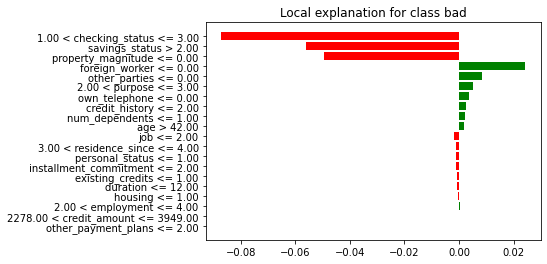

In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(dataset.X_train,
												   feature_names=dataset.F,
												   class_names=dataset.y_labels,
												   discretize_continuous=True)

# generate explanation
exp = explainer.explain_instance(dataset.X_test[case_id],
								 dataset.m.predict_proba,
								 num_features=len(dataset.F))

# save
exp.as_pyplot_figure()

# save as feature_importance map
fmap = exp.as_map()

# convert lime's output to feature import map interpretable by argueview
feature_importance, unexplained = feature_importance_from_lime(fmap, case)

## Build ArgueView model
After we successfully obtained feature importance we can start to build the argueview explanation
model. ArgueView is primarily a text-based explanation presentation tool. It's focus lies on
explaining decisions to end-users or laymen. Therefore, ArgueView relies heavily on textual input.

ArgueView contains a set of input methods to help you define text-based explanations for each case
scenario. In the current section we will illustrate how to build a text-based explanation model
for the CreditG dataset we use throughout this example.

### Toulmin's model of argumentation
ArgueView's explanation model is inspired by [Toulmin's model of argumentation](https://owl.purdue.edu/owl/general_writing/academic_writing/historical_perspectives_on_argumentation/toulmin_argument.html) 
(see van Eemeren, 2014). The following figure illustrates a possible model.

![CreditG Toulmin model](https://github.com/sophiahadash/argueview/blob/master/screenshots/toulmin-creditg.png?raw=true)

<sup>van Eemeren, F. H., Garssen, B., Krabbe, E. C. W., Snoeck Henkemans, A. F., Verheij, B., & Wagemans, J. H. M. (2014). Handbook of Argumentation Theory. https://doi.org/10.1007/978-90-481-9473-5</sup>

In [11]:
argView = ArgueView()

### Define classes
First, we have to define textual representations of our classes. Try to use names that are not 
too abstract.

In [12]:
argView.classes(["You are applicable for a loan.", "You are not applicable for a loan."])

### Define backing
Next, we define a backing. A backing should include why someone should trust your explanation. It can
contain descriptions of model accuracy, organizational credibility, or data credibility.

In [13]:
argView.backing("This decision is supported by Jheronimus Academy of Data Science, who have employed the automatic decision-making model RF-LOAN. This model is correct for 73% or the cases and is based on the German Credit dataset. This dataset is collected in 1994 by Dr. Hans Hofmann of Universität Hamburg, Institut für Statistik und Ökonometrie. The RF-LOAN model is developed by Sophia Hadash, who has been active in decision-making model development since 2017.")

### Define data source
Then we must add information on our data sources. In this example we only used one data source. This
information is obtained from the [OpenML data wiki](https://www.openml.org/d/31).

In [14]:
argView.add_data_source(Source({
	"name": 'German Credit',
	"author": 'Dr. Hans Hofmann, Universität Hamburg, Institut für Statistik und Ökonometrie',
	"description": 'This dataset classifies people described by a set of attributes as good or bad credit risks.',
	"href": 'https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)',
	"observations": 1000,
	"type": 'static',
	"year": 1994,
	"features": dataset.feature_data.feature
}))

### Define grounds
The most important step is to define your grounds. The grounds specify how each feature potentially 
contributes to the varying decision classes. For each feature we must describe why/how it 
hypothetically contributes to the decision classes. We describe this in a 2D-list, where the outer list
contains entries for each feature and the inner list contains an explanation for each decision-class.

Furthermore, these explanations are tokenized by feature value. This allows the explanations to vary
depending on both decision-class and feature value.

In [15]:
argView.grounds([
	["You have a sufficient amount on your checking account.",
	 "You have an insufficient amount on your checking account."],
	["We believe the duration of the credit is appropriate.",
	 "We believe the duration of the credit is not appropriate."],
	["Your credit history gives us confidence in your capabilities.",
	 "Your credit history does not give us confidence in your capabilities."],
	["We are interested in providing loans for <>.",
	 "We are generally not interested in providing loans for <>."],
	["Your credit amount gives us confidence in your capabilities.",
	 "Your credit amount does not give us sufficient confidence in your capabilities."],
	["Your savings give us confidence in your capabilities.",
	 "Your savings do not give us confidence in your capabilities."],
	["The duration of your current employment gives us confidence in your capabilities.",
	 "The duration of your current employment does not give us confidence in your capabilities."],
	["With the requested loan included, your installment rate is below the threshold.",
	 "The requested loan would increase your EMI over the threshold."],
	["We have more confidence in providing loans to <> in general.",
	 "We have less confidence in providing loans to <> in general."],
	["<> gives us confidence in your capabilities.",
	 "<> does not give us sufficient confidence in your capabilities."],
	["The duration of your current residence gives us confidence in your capabilities.",
	 "The duration of your current residence does not give us confidence in your capabilities."],
	["<> gives us confidence in your capabilities.", "<> does not give us confidence in your capabilities."],
	["Your age gives us confidence in your capabilities.",
	 " Your age does not give us confidence in your capabilities."],
	["<> gives us confidence in your capabilities.", "<> does not give us confidence in your capabilities."],
	["Living in <> increases the confidence we have in your capabilities.",
	 "Living in <> decreases the confidence we have in your capabilities."],
	["The amount of your credits gives us confidence in your capabilities.",
	 "The amount of your credits does not give us confidence in your capabilities."],
	["Your current employment responsibilities supports our confidence in your capabilities.",
	 "Your current employment responsibilities give us less confidence in your capabilities."],
	["The number of people that are liable to provide maintenance for gives us confidence in your capabilities.",
	"The number of people that are liable to provide maintenance for does not give us confidence in your capabilities."],
	["The <> telephone gives us confidence in your capabilities.",
	 "The <> telephone does not give us confidence in your capabilities."],
	["Because you are <>a foreign worker, we have more confidence in your capabilities.",
	 "Because you are <>a foreign worker, we have less confidence in your capabilities."],
], [
	[],
	[],
	[],
	["the purpose of buying a new car", "the purpose of buying a used car",
	 "the purpose of buying furniture or equipment", "the purpose of buying a radio or tv",
	 "the purpose of buying domestic appliance", "the purpose of making repairs",
	 "the purpose of gaining education", "the purpose of paying for vacation", "the purpose of retraining",
	 "the purpose of investing in business", "unspecified purposes"],
	[],
	[],
	[],
	[],
	["divorced or separated males", "females", "single males", "married or widowed males", "single females"],
	["The lack of a co-applicant or guarantor", "Your co-applicant", "Your guarantor"],
	[],
	["Your real-estate", "Your life insurance", "The fact that you own a car", "The absence of known property"],
	[],
	["Your installment plan at a bank", "Your installment plan at a store",
	 "Having no other installment plans"],
	["rented housing", "owned housing", "free housing"],
	[],
	[],
	[],
	["lack of ownership of a", "ownership of a"],
	["", "not "],
])

## Generate explanation
After the argueview explanation model is built, we are ready to generate our explanation.

In [16]:
explanation = argView.generate(case, feature_importance, unexplained)
explanation.print(True)

Explanation
class: You are applicable for a loan.
leading rationale:You have a sufficient amount on your checking account.
qualifier: The class 'You are applicable for a loan.' is 78% more certain than the other possible classes.
backing: This decision is supported by Jheronimus Academy of Data Science, who have employed the automatic decision-making model RF-LOAN. This model is correct for 73% or the cases and is based on the German Credit dataset. This dataset is collected in 1994 by Dr. Hans Hofmann of Universität Hamburg, Institut für Statistik und Ökonometrie. The RF-LOAN model is developed by Sophia Hadash, who has been active in decision-making model development since 2017.

Source: German Credit
checking_status        = no checking        , contribution = 0.08724859956202008
duration               = 12.0               , contribution = 0.0007815444896481222
credit_history         = existing paid      , contribution = -0.0026936365611135646
purpose                = radio/tv      